# Projet Fil Rouge : Variational AutoEncoder (VAE) for anomaly detection based on the electrical load curve

## Import libs

In [1]:
# --- ultils libs ---

from typing import List, Set, Dict, Tuple, Optional, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Machine Learning libs ---
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statistics

# --- Deep Learning Libs ---
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Lambda, MaxPooling1D
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam, Adadelta
from tensorflow.keras.models import load_model
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from keras.wrappers.scikit_learn import KerasRegressor

# import this because we use custom loss function
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# --- Options ---
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Load and Preprocessed Dataset

In [2]:
def load_dataset(filename: str, resample_period :Optional[str]=None) -> pd.DataFrame:
    """
    Loads the dataset
    filename: the path to the file to load
    resample_period: (optional) the reasmple period, if None the default period of 1 second will be used
    returns: a DataFrame containing the dataset
    """
    dataset = pd.read_csv(filename, index_col='datetime').interpolate('linear')
    dataset.index = pd.to_datetime(dataset.index)
    dataset = dataset.asfreq('s')

    if resample_period:
        dataset = dataset.resample(resample_period).nearest()
    
    dataset['hour'] = dataset.index.hour + dataset.index.minute / 60 #+ dataset.index.seconde / 3600

    return dataset

In [3]:
def load_preproc_dataset():
    raw_dataset = pd.read_csv("data/house1_power_blk2_labels.csv", index_col='datetime').interpolate('linear')
    raw_dataset.index = pd.to_datetime(raw_dataset.index)
    raw_dataset = raw_dataset.asfreq('s')

    dataset_resampled = load_dataset("data/house1_power_blk2_labels.csv", "5min")
    dataset_mains_resampled = dataset_resampled["mains"]
    dataset_mains_resampled

    start_time = raw_dataset.index[0]

    #transform to numpy array of 24*356*4 elements
    M = np.array(dataset_mains_resampled)
    lenght = M.shape[0]
    M = M[:-(lenght%24)]
    M = M.reshape(lenght//24,24)

    M = M[~np.all(M == 0, axis=1)]

    M = M.reshape(len(M),24,1)
    for i in range(len(M)):
        M[i] = np.roll(M[i], -start_time.hour)

    #M = preprocessing.normalize(M)
    M = M/(max([max(x) for x in M]))

    U = []
    for x in M:
        RAN = np.array([random.uniform(0, 2) for i in range(24)])
        RAN = np.expand_dims(RAN,axis=1)
        y = x*RAN
        U.append(y)
    V = []
    for x in M:
        RAN = np.array([random.uniform(0, 2) for i in range(24)])
        RAN = np.expand_dims(RAN,axis=1)
        y = x*RAN
        V.append(y)

    for i in range(len(U)):
        U[i] = np.roll(U[i], 8)
        V[i] = np.roll(V[i], -8)

    dada = [0 for i in range(len(M))]
    x_train, x_test, _, __ = train_test_split(M, dada, test_size=0.20)
    u_train, u_test, _, __ = train_test_split(U, dada, test_size=0.20)
    v_train, v_test, _, __ = train_test_split(V, dada, test_size=0.20)

    u_train = np.array(u_train)
    u_test = np.array(u_test)

    return x_train, x_test, u_train, u_test, v_train, v_test 

In [4]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Prepare latent data for classification

In [5]:
def class_preprocess(latent_test, latent_ran_test):
    L = []
    len(L)
    for x in latent_test:
        L.append([x,0])
    for x in latent_ran_test:
        L.append([x,1])

    L = np.array(L)
    np.random.shuffle(L)
    L.shape
    L[0]
    L[1]

    inputs = [x[0] for x in L]
    targets = [x[1] for x in L]
    
    print("-- Input --")
    print(inputs)
    
    print("\n\n-- Targets --")
    print(targets)

    return inputs, targets

### Define VAE

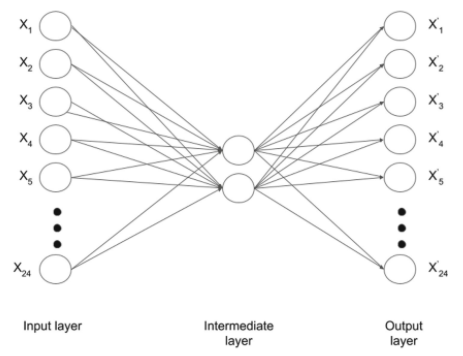

In [6]:
def var_shallow(optimizer='Nadam', mid_activation='linear', out_activation='sigmoid', kl_coef=1):
    
    def my_vae_loss(y_true, y_pred):
        reconstruction_loss = 24*categorical_crossentropy(y_true, y_pred)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - 0.001*K.square(z_mean) - K.exp(z_log_var), axis=-1)

        vae_loss = K.mean(reconstruction_loss + kl_coef*kl_loss)
        return vae_loss


    input_window = Input(shape=(window_length,))

    z_mean = Dense(latent_size, name='z_mean', activation=mid_activation)(input_window)
    z_log_var = Dense(latent_size, name='z_log_var', activation=mid_activation)(input_window)
    
    z = Lambda(sampling, output_shape=(latent_size,), name='z')([z_mean, z_log_var])
    z = Activation('sigmoid')(z)

    decoded = Dense(window_length, activation=out_activation)(z)

    encoder = Model(input_window, [z_mean, z_log_var, z])
    autoencoder = Model(input_window, decoded)

    autoencoder.compile(optimizer=optimizer, loss=my_vae_loss)
    
    return autoencoder, encoder


## Build train set and test set

In [7]:
x_train, x_test, x_train_shifted_8, x_test_shifted_8, v_train, v_test  = load_preproc_dataset()
x_train = np.squeeze(x_train, axis=2)
x_test = np.squeeze(x_test, axis=2)
x_train_shifted_8 = np.squeeze(x_train_shifted_8, axis=2)
x_test_shifted_8 = np.squeeze(x_test_shifted_8, axis=2)
v_train = np.squeeze(v_train, axis=2)
v_test = np.squeeze(v_test, axis=2)

#train_set = np.concatenate((x_train,x_train_shifted_8), axis=0)
train_set = x_train
test_set = x_test
pos_shifted_train_set = x_train_shifted_8
pos_shifted_set = x_test_shifted_8
neg_shifted_set = v_test

#train
features_matrix_train, labels_train = class_preprocess(x_train, x_train_shifted_8)
features_matrix_train = np.array(features_matrix_train)
labels_train = np.array(labels_train)

#test
features_matrix_test, labels_test = class_preprocess(x_test, x_test_shifted_8)
features_matrix_test = np.array(features_matrix_test)
labels_test = np.array(labels_test)

-- Input --
[array([0.00968013, 0.08458519, 0.04234202, 0.03743547, 0.15197586,
       0.00681276, 0.08118731, 0.03773226, 0.04741029, 0.12396447,
       0.38981362, 0.16643773, 0.16808681, 0.05184936, 0.09315049,
       0.06343428, 0.17959124, 0.01398388, 0.0744627 , 0.21637076,
       0.14903723, 0.0780513 , 0.08937448, 0.01438747]), array([0.08286951, 0.05947227, 0.05071119, 0.04895898, 0.04926819,
       0.04998969, 0.07503608, 0.0615337 , 0.03710575, 0.05813234,
       0.07513915, 0.05060812, 0.04937126, 0.04968048, 0.03617811,
       0.07534529, 0.06184292, 0.03720882, 0.06050299, 0.07410843,
       0.03720882, 0.04844362, 0.04906205, 0.06441971]), array([0.07689136, 0.04895898, 0.04834055, 0.04885591, 0.04906205,
       0.04844362, 0.06029685, 0.04875283, 0.07771593, 0.07555143,
       0.04957741, 0.04906205, 0.06277056, 0.05019584, 0.04957741,
       0.06163678, 0.04854669, 0.06256442, 0.06338899, 0.05071119,
       0.06204906, 0.06318285, 0.03741497, 0.04957741]), array([0.056

## Define hyperparameters

- ``latent_size`` : 2
- ``window_length`` : 24
- ``optimizer`` : Nadam
- ``loss`` : custom loss
- ``mid_activation`` : sigmoid
- ``out_activation`` : sigmoid

In [8]:
latent_size = 2
window_length=24
optimizer='Nadam'
mid_activation='sigmoid'
out_activation='sigmoid'

## Train the AE

- ``batch_size`` : 32
- ``epochs``: 200

In [9]:
autoencoder, encoder = var_shallow()
history = autoencoder.fit(train_set, train_set,
                epochs=200,
                batch_size=32, shuffle=True)

Train on 604 samples
Epoch 1/200
604/604 [==============================] - 1s 1ms/sample - loss: 214.2098
Epoch 2/200
604/604 [==============================] - 0s 46us/sample - loss: 214.3698
Epoch 3/200
604/604 [==============================] - 0s 44us/sample - loss: 214.3262
Epoch 4/200
604/604 [==============================] - 0s 37us/sample - loss: 214.5527
Epoch 5/200
604/604 [==============================] - 0s 36us/sample - loss: 214.5874
Epoch 6/200
604/604 [==============================] - 0s 37us/sample - loss: 214.8442
Epoch 7/200
604/604 [==============================] - 0s 40us/sample - loss: 215.0008
Epoch 8/200
604/604 [==============================] - 0s 39us/sample - loss: 215.0972
Epoch 9/200
604/604 [==============================] - 0s 40us/sample - loss: 215.2630
Epoch 10/200
604/604 [==============================] - 0s 43us/sample - loss: 215.3235
Epoch 11/200
604/604 [==============================] - 0s 41us/sample - loss: 215.6134
Epoch 12/200
604/604 

604/604 [==============================] - 0s 43us/sample - loss: 216.1075
Epoch 93/200
604/604 [==============================] - 0s 40us/sample - loss: 216.0979
Epoch 94/200
604/604 [==============================] - 0s 38us/sample - loss: 216.0972
Epoch 95/200
604/604 [==============================] - 0s 41us/sample - loss: 216.0914
Epoch 96/200
604/604 [==============================] - 0s 38us/sample - loss: 216.0845
Epoch 97/200
604/604 [==============================] - 0s 40us/sample - loss: 216.0676
Epoch 98/200
604/604 [==============================] - 0s 40us/sample - loss: 216.0594
Epoch 99/200
604/604 [==============================] - 0s 40us/sample - loss: 216.0611
Epoch 100/200
604/604 [==============================] - 0s 41us/sample - loss: 216.0495
Epoch 101/200
604/604 [==============================] - 0s 39us/sample - loss: 216.0441
Epoch 102/200
604/604 [==============================] - 0s 41us/sample - loss: 216.0443
Epoch 103/200
604/604 [===================

604/604 [==============================] - 0s 40us/sample - loss: 215.6525
Epoch 185/200
604/604 [==============================] - 0s 40us/sample - loss: 215.6473
Epoch 186/200
604/604 [==============================] - 0s 40us/sample - loss: 215.6425
Epoch 187/200
604/604 [==============================] - 0s 46us/sample - loss: 215.6402
Epoch 188/200
604/604 [==============================] - 0s 46us/sample - loss: 215.6331
Epoch 189/200
604/604 [==============================] - 0s 43us/sample - loss: 215.6330
Epoch 190/200
604/604 [==============================] - 0s 41us/sample - loss: 215.6286
Epoch 191/200
604/604 [==============================] - 0s 50us/sample - loss: 215.6257
Epoch 192/200
604/604 [==============================] - 0s 48us/sample - loss: 215.6205
Epoch 193/200
604/604 [==============================] - 0s 46us/sample - loss: 215.6197
Epoch 194/200
604/604 [==============================] - 0s 50us/sample - loss: 215.6164
Epoch 195/200
604/604 [============

## Get the latent space of the AE

In [10]:
latent_train = encoder.predict(train_set)
latent_shifted_train = encoder.predict(pos_shifted_train_set)
latent_test = encoder.predict(test_set)
latent_shifted_pos = encoder.predict(pos_shifted_set)

print(latent_test)

#extract means
mean_train = latent_train[0]
mean_shifted_train = latent_shifted_train[0]
mean_test = latent_test[0]
mean_shifted_pos = latent_shifted_pos[0]

#extract vars
var_train = latent_train[1]
var_shifted_train = latent_shifted_train[1]
var_test = latent_test[1]
var_shifted_pos = latent_shifted_pos[1]

[array([[ 7.9259834,  8.092535 ],
       [ 5.7096014,  5.857469 ],
       [ 5.05165  ,  5.1865396],
       [ 4.905526 ,  5.0415196],
       [ 5.7248125,  5.8870516],
       [ 5.6035423,  5.791446 ],
       [ 5.3621206,  5.508043 ],
       [ 5.8797493,  6.075005 ],
       [12.485506 , 12.774751 ],
       [12.003381 , 12.052197 ],
       [ 5.131529 ,  5.2643986],
       [ 7.74284  ,  7.894661 ],
       [ 5.513221 ,  5.650704 ],
       [ 9.445998 ,  9.449813 ],
       [ 9.314843 ,  9.504772 ],
       [ 6.5415535,  6.637142 ],
       [ 5.405411 ,  5.5558314],
       [ 7.5968246,  7.6717367],
       [ 8.337265 ,  8.463597 ],
       [ 5.350354 ,  5.4886274],
       [ 7.78911  ,  7.899803 ],
       [ 5.111683 ,  5.224291 ],
       [ 5.3038845,  5.4526854],
       [13.246207 , 13.460519 ],
       [ 9.120695 ,  9.700365 ],
       [10.321914 , 10.725234 ],
       [ 4.804079 ,  4.919054 ],
       [ 6.082244 ,  6.2288027],
       [ 6.0110683,  6.214491 ],
       [ 8.637918 ,  8.948601 ],
       [ 

### Rearange it into a 4-dim vectors to be fed to the classifier

In [11]:
#rearange it into a 4-dim vectors to be fed to the classifier

x,y = mean_train.T
w,z = var_train.T
c = zip(x,y,w,z)
latent_train = np.array(list(c))

x,y = mean_shifted_train.T
w,z = var_shifted_train.T
c = zip(x,y,w,z)
latent_shifted_train = np.array(list(c))

x,y = mean_test.T
w,z = var_test.T
c = zip(x,y,w,z)
latent_test = np.array(list(c))

x,y = mean_shifted_pos.T
w,z = var_shifted_pos.T
c = zip(x,y,w,z)
latent_shifted_pos = np.array(list(c))

## Visualize the latent space

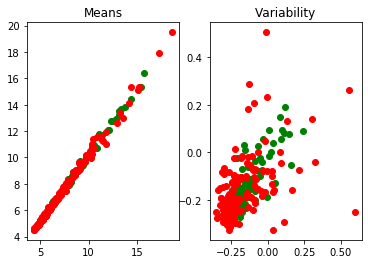

In [12]:
if latent_size == 2:
    X,Y,W,Z = latent_test.T
    XN,YN,WN,ZN = latent_shifted_pos.T
    #XNN,YNN = latent_shifted_neg.T
    plt.subplot(1, 2, 1)
    plt.plot(X, Y, 'go')
    plt.plot(XN, YN, 'ro')
    plt.title('Means')
    plt.subplot(1, 2, 2)
    plt.plot(W, Z, 'go')
    plt.plot(WN, ZN, 'ro')
    plt.title('Variability')
    #plt.plot(XNN, YNN, 'yo')
elif latent_size ==3:
    from mpl_toolkits.mplot3d import axes3d

    data = (latent_test, latent_shifted_pos,latent_shifted_neg)
    colors = ("green", "red", "yellow")
    groups = ("normal", "anomaly", "anomaly")

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = fig.gca(projection='3d')


    #X,Y,Z = latent_test.T
    #XN,YN,ZN = latent_shifted_pos.T
    for data, color, group in zip(data, colors, groups):
        x, y, z = data.T
        ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
else:
    pass

## Build train set and test set for the classifier model

In [13]:
#train
features_matrix_train, labels_train = class_preprocess(latent_train, latent_shifted_train)

#test
features_matrix_test, labels_test = class_preprocess(latent_test, latent_shifted_pos)

-- Input --
[array([ 6.195563  ,  6.4133663 , -0.23275772, -0.20950305], dtype=float32), array([ 4.5425982 ,  4.6640935 , -0.27081925, -0.31254363], dtype=float32), array([ 9.955626  , 10.323557  , -0.03117269,  0.0171904 ], dtype=float32), array([ 9.901251  ,  9.947508  , -0.25890845, -0.27016908], dtype=float32), array([ 7.0762167 ,  7.197983  , -0.17851764, -0.16192648], dtype=float32), array([ 6.662528  ,  6.967412  , -0.19857621, -0.252902  ], dtype=float32), array([1.3304219e+01, 1.4062850e+01, 5.8832049e-02, 5.0506890e-03],
      dtype=float32), array([ 5.1629505 ,  5.296487  , -0.26932642, -0.2530398 ], dtype=float32), array([ 5.017581  ,  5.1316566 , -0.2716695 , -0.26270103], dtype=float32), array([12.937774  , 13.1271    , -0.13773152,  0.0321247 ], dtype=float32), array([ 8.704714  ,  9.03057   , -0.03755736,  0.01505581], dtype=float32), array([ 9.03244   ,  8.89946   , -0.12476659, -0.13315523], dtype=float32), array([ 5.405742  ,  5.416613  , -0.28619403, -0.23261733], d

## Train the classifier model

In [14]:
#create and train the classifier
classifier = RandomForestClassifier()
classifier.fit(features_matrix_train, labels_train)

RandomForestClassifier()

## Predict and Evaluate

In [15]:
#predict and evaluate
predicted_labels_test = classifier.predict(np.array(features_matrix_test))
print(confusion_matrix(labels_test,predicted_labels_test))
print(classification_report(labels_test,predicted_labels_test))

[[120  31]
 [ 44 107]]
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       151
           1       0.78      0.71      0.74       151

    accuracy                           0.75       302
   macro avg       0.75      0.75      0.75       302
weighted avg       0.75      0.75      0.75       302

